# Técnicas de Suavizado


Las técnicas de suavizado de series temporales se utilizan ampliamente en economía, meteorología, ecología y otros campos que manejan datos recopilados a lo largo del tiempo. El suavizado de datos temporales a menudo revela tendencias o ciclos a largo plazo mientras suaviza el ruido y las fluctuaciones a corto plazo.[link](https://pro.arcgis.com/es/pro-app/latest/tool-reference/spatial-statistics/how-time-series-smoothing-works.htm)

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [43]:
airline = pd.read_csv("../../DataSets/airline_passengers.csv", index_col = 'Month', parse_dates = True)

In [44]:
airline.index #Fíjate que no tenemos puesta la frecuqencia

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [45]:
# ponemos la frecuencia

airline.index.freq = 'MS'
airline.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq='MS')

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [46]:
airline.isna().sum()


Thousands of Passengers    0
dtype: int64

## Simple movil average: Promedio móvil simple

El promedio estimado corresponde a:$$SMA = \frac{x_1 + x_2 + ... + x_n}{n}$$

donde $x_i$ son los valores de la variable, por tanto $SMA$ es un promedio aritmético de $n$ periodos atrás.

In [47]:
# Generando nuevcas estimaciones con una ventana de tiempo. No hay medias para los primeros valores. 
# fíjate que le doy la misma importancia a los retrasos en la ponderación
# rolling(window = n) selecciona un espacio temporal (n momentos en el tiempo)


airline['6-month-SMA'] = airline['Thousands of Passengers'].rolling(window = 6).mean()
airline['12-month-SMA'] = airline['Thousands of Passengers'].rolling(window = 12).mean()
airline.head(16)



,Thousands of Passengers,6-month-SMA,12-month-SMA
Month,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,NaN,NaN
1949-03-01,132,NaN,NaN
1949-04-01,129,NaN,NaN
1949-05-01,121,NaN,NaN
1949-06-01,135,124.500000,NaN
1949-07-01,148,130.500000,NaN
1949-08-01,148,135.500000,NaN
1949-09-01,136,136.166667,NaN


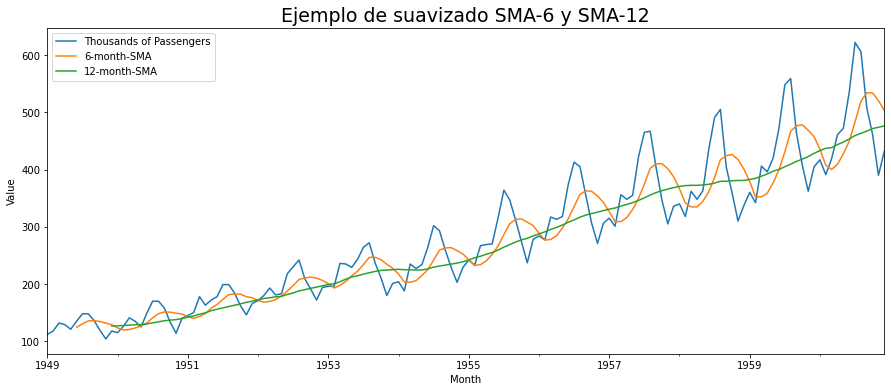

In [48]:
# Gráfica de data de aerolinea

airline.plot(figsize = (15,6))
plt.title("Ejemplo de suavizado SMA-6 y SMA-12", size = 19)
plt.ylabel("Value")
plt.show()


# Promedio móvil ponderado exponencialmente (EWMA)

Nos permite reducir el efecto de retraso de SMA y pondrá más peso en los valores que ocurren recientemente.  La fórnmula 
es: 
$$y_t = \frac{\sum_{i = 0}^t w_i x_{t-1}}{\sum_{i = 0}^t w_i}$$

Donde $x_t$ son los valores de la variable $w_i$ son los pesos(desde $i = 0$ hasta $t$) y $y_t$ es la estimación resultante.

¿Cómo se definen los pesos? - depende del parámetro 'adjust' dentro de la función '.ewm()'.

Cuando `adjust = True` (por defecto), los pesos se calculan como $w_i = (1-\alpha)^i$

Lo cual resulta en estas estimaciones:


$$y_t=\frac{x_t+(1-\alpha)x_{t-1}+(1-\alpha)^2 x_{t-2}+...+(1-\alpha)^t x_0}{1+(1-\alpha)+(1-\alpha)^2+...+(1-\alpha)^t}$$


Cuando `adjust = False` las estimaciones se calculan como:

$y_0 = x_0$

$y_t = (1-\alpha)y_{t-1} + \alpha x_t$

Mientras más grande $\alpha$ menos peso doy. La expresión anterior, es equivalente a


$$w_i = \left\{ \begin{array}{lcc}
   \alpha(1-\alpha)^i & si & i < t \\
    (1-\alpha)^i      & si & i = t
    \end{array}
    \right.$$

El parámetro de suavizado $\alpha$ tiene que ser una valor $0 < \alpha \le 1$.

Es posible pasar directamente el valor del parámetro, pero una mejor práctica es pensar en él como una función  de estos
tres posibles factores:


$$\alpha = \left\{ \begin{array}{lcc}
   \frac{2}{s+1}                & para\ una\ duración\ (span) & 1 \le s \\
    \frac{1}{1+c}               & para\ un\ centro\ de\ masa  & 0 \le c \\
    1-\exp^{\frac{log 0.5}{h}}  & para\ un\ parámetro\ half-life\ & h >0  \\
    \end{array}
    \right.$$

  - *Span* corresponde a un promedio móvil de N-periodos
  - *Center of mass* pensado en términos de la duración: $c = (s - 1)/1$
  - *Half-life* es el periodo de tiempo para que el peso exponencial se reduzca a la mitad
  - **Alpha** es el parámetro de suavizado.


In [49]:
# EWMA

# Si queremos condierar un span de 12 meses

airline['EWMA12'] = airline['Thousands of Passengers'].ewm(span = 12, adjust = False).mean()
airline.head()

,Thousands of Passengers,6-month-SMA,12-month-SMA,EWMA12
Month,,,,
1949-01-01,112,NaN,NaN,112.000000
1949-02-01,118,NaN,NaN,112.923077
1949-03-01,132,NaN,NaN,115.857988
1949-04-01,129,NaN,NaN,117.879836
1949-05-01,121,NaN,NaN,118.359861


<AxesSubplot:xlabel='Month'>

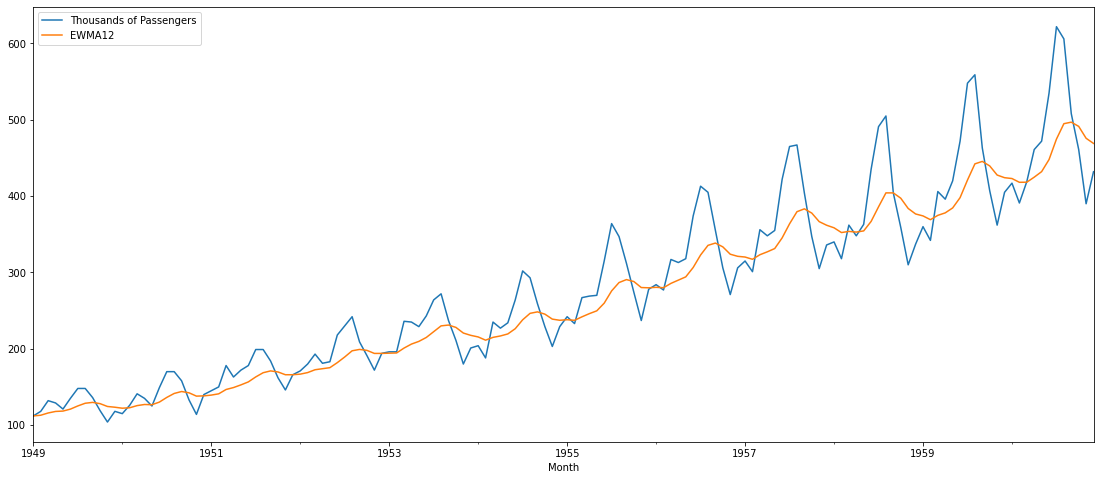

In [50]:
airline[['Thousands of Passengers','EWMA12']].plot(figsize = (19,8)) # los puntos más cercanos tienen más peso

<AxesSubplot:xlabel='Month'>

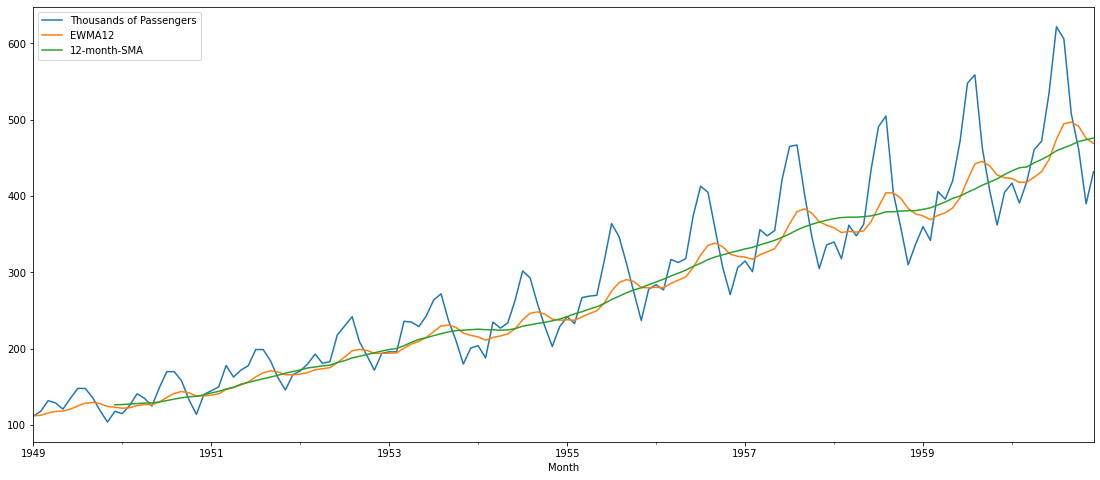

In [51]:
airline[['Thousands of Passengers','EWMA12','12-month-SMA']].plot(figsize = (19,8)) 
# EWMA es menos suave pero mejor que SMA EWMA12 recoge mejor la info
                                                                                

# Suavizado exponencial simple

El ejemplo anterior hemos empleado una especie de *Suavizado exponencial simple* con un factor de suiavizado $\alpha$. Desafortunadamente, esta técnica hace un mal trabajo de pronóstico cuando hay una tendencia en los datos como se ve arriba . 
En el siguiente ítem veremos suavizado exponencial doble o triple con el método Holt-Winters.

# Holt- Winters Methods


En la clase anterior vimos los **Promedios móviles ponderados exponencialmente**(EWMA) que es un *Suavizado simple* usando un solo factor de suavizado $\alpha$. Pero no tuvo en cuenta otros factores que contribuyen , como la tendencia y la estacionalidad.

En el **Suavizado exponencial doble** (o *Método de Holt*) presentamos un nuevo factor de suavizado $\beta$ (beta) que aborda en la tendencia:

     - Nivel:
$$l_t = (1-\alpha)l_{t-1}+ \alpha x_t$$  

     - Tendencia:
$$b_t = (1- \beta)b_{t-1}+ \beta (l_t - l_{t-1})$$   

     - Modelo estimado:
$$y_t = l_t + b_t$$        

     - Modelo de pronósticos (h = Cantidad de periodos en el futuro)
$$\hat{y}_{t+h}= l_t+hb_t$$



En el **Suavizado exponencial triple** (o *Método de Holt-Winters*) presentamos un nuevo factor de suavizado $\gamma$ (gamma) que aborda en la estacionalidad:


      - Nivel:
$$l_t = (1-\alpha)l_{t-1}+ \alpha x_t$$  

      - Tendencia:
$$b_t = (1- \beta)b_{t-1}+ \beta (l_t - l_{t-1})$$

      - Estacionalidad
 $$c_t=(1-\gamma)c_{t-L}+\gamma(x_t-l_{t-1}-b_{t-1})$$     
 
      - Modelo estimado:
$$y_t = (l_t + b_t)c_t$$        

      - Modelo de pronósticos (m = Cantidad de periodos en el futuro)
$$\hat{y}_{t+m}= (l_t+mb_t)c_{t-L+1+(m-1)modL}$$

donde $L$ representa el número de divisiones por ciclo. En nuestro caso, mirando datos mensuales que muestran un patrón repetitivo cada año, usaríamos 12.


En general, los valores más altos para $\alpha, \ \beta\ y\ \gamma$ (a 1) pone más énfasis en datos recientes. 


In [52]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

span = 12
alpha = 2/(span+1)

airline['EWMA12'] = airline['Thousands of Passengers'].ewm(alpha=alpha,adjust=False).mean()
airline['SES12']=SimpleExpSmoothing(airline['Thousands of Passengers']).fit(smoothing_level=alpha,optimized=False).fittedvalues.shift(-1)
airline.head(15)

C:\Users\sept\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


,Thousands of Passengers,6-month-SMA,12-month-SMA,EWMA12,SES12
Month,,,,,
1949-01-01,112,NaN,NaN,112.000000,112.000000
1949-02-01,118,NaN,NaN,112.923077,112.923077
1949-03-01,132,NaN,NaN,115.857988,115.857988
1949-04-01,129,NaN,NaN,117.879836,117.879836
1949-05-01,121,NaN,NaN,118.359861,118.359861
1949-06-01,135,124.500000,NaN,120.919883,120.919883
1949-07-01,148,130.500000,NaN,125.086055,125.086055
1949-08-01,148,135.500000,NaN,128.611277,128.611277
1949-09-01,136,136.166667,NaN,129.748004,129.748004


# Suavizado exponencial doble

In [53]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

airline['DESadd12'] = ExponentialSmoothing(airline['Thousands of Passengers'], trend = 'add').fit().fittedvalues.shift(-1)
airline.head()

C:\Users\sept\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


,Thousands of Passengers,6-month-SMA,12-month-SMA,EWMA12,SES12,DESadd12
Month,,,,,,
1949-01-01,112,NaN,NaN,112.000000,112.000000,113.474828
1949-02-01,118,NaN,NaN,112.923077,112.923077,119.464366
1949-03-01,132,NaN,NaN,115.857988,115.857988,133.477561
1949-04-01,129,NaN,NaN,117.879836,117.879836,130.543312
1949-05-01,121,NaN,NaN,118.359861,118.359861,122.528126


<AxesSubplot:xlabel='Month'>

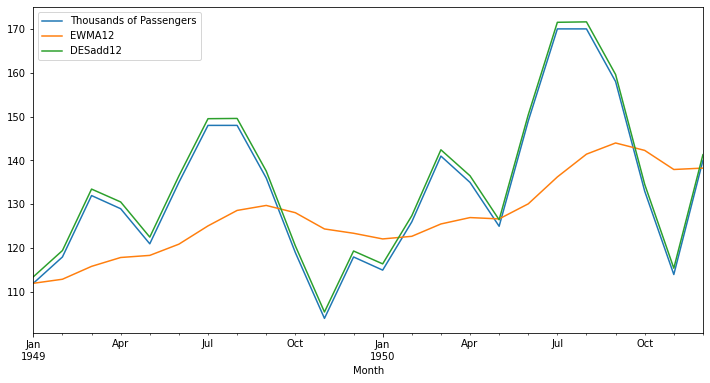

In [54]:
# grafica. Fíjate como se superponen las gràficas con el modelo exponencial

airline[['Thousands of Passengers', 'EWMA12','DESadd12']].iloc[:24].plot(figsize = (12,6))

In [55]:
# Considerando la función multiplicativa


airline['DESmul12'] = ExponentialSmoothing(airline['Thousands of Passengers'], trend = 'mul').fit().fittedvalues.shift(-1)
airline.head()

C:\Users\sept\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


,Thousands of Passengers,6-month-SMA,12-month-SMA,EWMA12,SES12,DESadd12,DESmul12
Month,,,,,,,
1949-01-01,112,NaN,NaN,112.000000,112.000000,113.474828,114.978251
1949-02-01,118,NaN,NaN,112.923077,112.923077,119.464366,121.191659
1949-03-01,132,NaN,NaN,115.857988,115.857988,133.477561,135.802180
1949-04-01,129,NaN,NaN,117.879836,117.879836,130.543312,132.657709
1949-05-01,121,NaN,NaN,118.359861,118.359861,122.528126,124.213566


<AxesSubplot:xlabel='Month'>

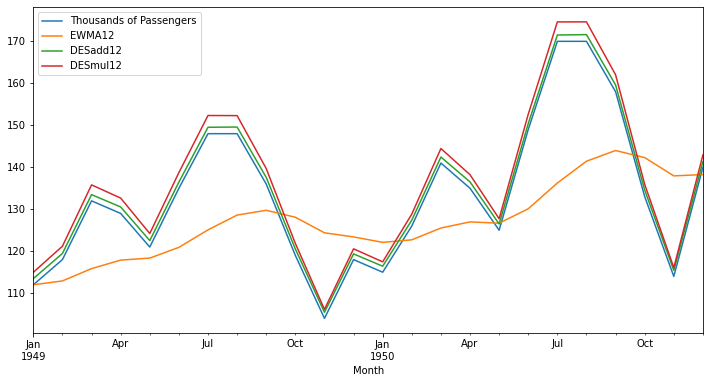

In [56]:
# grafica. Fíjate como se superponen las gràficas con el modelo exponencial

airline[['Thousands of Passengers', 'EWMA12','DESadd12', 'DESmul12']].iloc[:24].plot(figsize = (12,6))

# Suavizado exponencial triple
Suavizado exponencial triple o Holt-Winters, añade soporte para la tendencia y la estacionalidad.


In [57]:
airline['TESadd12'] = ExponentialSmoothing(airline['Thousands of Passengers'], trend = 'add',  seasonal = 'add', seasonal_periods = 12).fit().fittedvalues.shift(-1)
airline.head()

C:\Users\sept\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


,Thousands of Passengers,6-month-SMA,12-month-SMA,EWMA12,SES12,DESadd12,DESmul12,TESadd12
Month,,,,,,,,
1949-01-01,112,NaN,NaN,112.000000,112.000000,113.474828,114.978251,120.168193
1949-02-01,118,NaN,NaN,112.923077,112.923077,119.464366,121.191659,134.698694
1949-03-01,132,NaN,NaN,115.857988,115.857988,133.477561,135.802180,131.376310
1949-04-01,129,NaN,NaN,117.879836,117.879836,130.543312,132.657709,124.628035
1949-05-01,121,NaN,NaN,118.359861,118.359861,122.528126,124.213566,140.414919


In [58]:
airline['TESmul12'] = ExponentialSmoothing(airline['Thousands of Passengers'], trend = 'mul',  seasonal = 'mul', seasonal_periods = 12).fit().fittedvalues.shift(-1)
airline.head()

C:\Users\sept\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\sept\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


,Thousands of Passengers,6-month-SMA,12-month-SMA,EWMA12,SES12,DESadd12,DESmul12,TESadd12,TESmul12
Month,,,,,,,,,
1949-01-01,112,NaN,NaN,112.000000,112.000000,113.474828,114.978251,120.168193,118.844235
1949-02-01,118,NaN,NaN,112.923077,112.923077,119.464366,121.191659,134.698694,133.334951
1949-03-01,132,NaN,NaN,115.857988,115.857988,133.477561,135.802180,131.376310,127.901291
1949-04-01,129,NaN,NaN,117.879836,117.879836,130.543312,132.657709,124.628035,120.978657
1949-05-01,121,NaN,NaN,118.359861,118.359861,122.528126,124.213566,140.414919,133.904839


<AxesSubplot:xlabel='Month'>

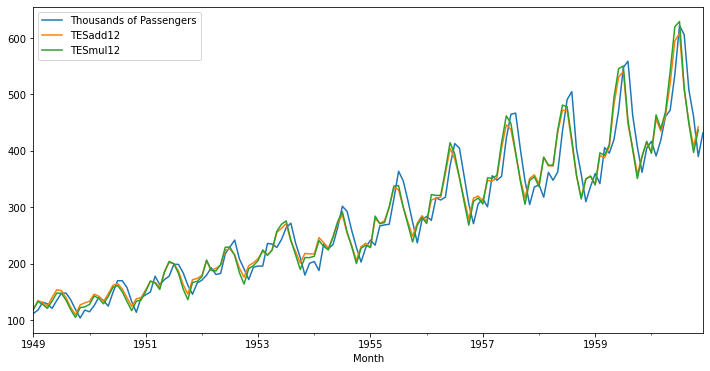

In [59]:
airline[['Thousands of Passengers','TESadd12','TESmul12']].plot(figsize=(12,6))

In [60]:
# Si quisieramos hacer predicciones 

model_add = ExponentialSmoothing(airline['Thousands of Passengers'], trend = 'add',  seasonal = 'add', seasonal_periods = 12).fit()

C:\Users\sept\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [61]:
model_mul = ExponentialSmoothing(airline['Thousands of Passengers'], trend = 'mul',  seasonal = 'mul', seasonal_periods = 12).fit()

C:\Users\sept\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


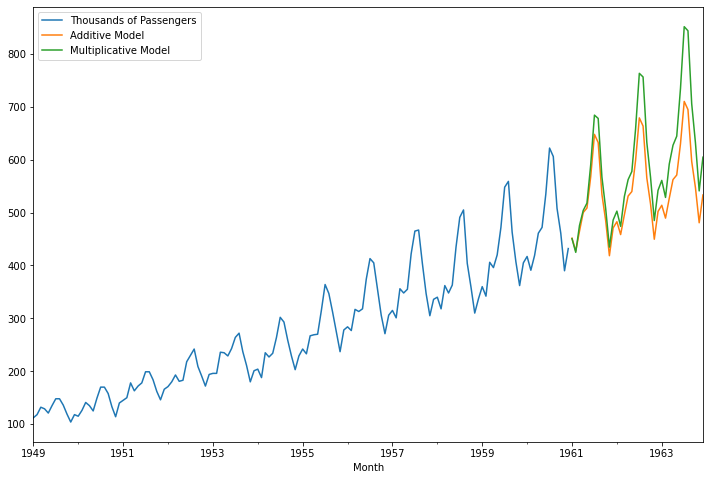

In [63]:
# Forecast

forecast_add = model_add.forecast(36)
forecast_mul = model_mul.forecast(36)

# grafica de forecast

airline['Thousands of Passengers'].plot(figsize=(12,8))
forecast_add.plot(label = 'Additive Model')
forecast_mul.plot(label = 'Multiplicative Model')
plt.legend(loc = 'upper left')
